In [50]:
%matplotlib notebook

In [51]:
import os
import re

import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt
from scipy.stats import spearmanr, pearsonr

# pd.options.display.html.table_schema = True

# Problem Statement

Often data is incomplete, redundant or degenerate because data stores are developed to capture all the data that *may* be useful, not just the data that *is useful today*. In these instances, as a data scientist, one must exclude that missing, redundant, or degenerate data.

# Solution Explored in this Notebook

1. Use `pandas` to exclude incomplete data,
2. evaluate the [Spearman](https://en.wikipedia.org/wiki/Spearman%27s_rank_correlation_coefficient) and [Pearson](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) correlation coefficients to identify the redundancy/degeneracy of the data, and
3. use the selected correlation matrix as the distance metric in a agglomerative hierarchical clustering algorithm to identify correlations.

# Next Steps

1. From these correlations, reduce the number of input/output variables,
2. feed these into classification/regression algorithms.

This notebook was inspired by a presentation given by Amit Verma on 14 April 2020.

# Read in the data

In [2]:
data = pd.read_csv("data/citrination-export-20200414.csv");

# set index
data.set_index("Name", inplace=True)

# remove uncertainty
columns = [col for col in data.columns if not col.startswith("Uncertainty")]
data = data[columns]

# remove probability
columns = [col for col in data.columns if not col.endswith("probability")]
data = data[columns]

# remove "Property" from column names
columns = [re.sub("Property ", "", col) for col in data.columns]
data.columns = columns

# remove columns whose records are all identical (degenerate columns)
# columns = [c for c in data.columns if np.all(data[c] == data.loc[0, c])]
# data.drop(columns, axis=1)

# remove statistical values
columns = [col for col in data.columns if not col.startswith("mean")]
data = data[columns]

data

,Alpha lath thickness (microns),"Bead quality (1-intermittent, 2-variable, 3-rippled, 4-smooth)",Bead width (mm),Beta grain length // build (microns),Beta grain length perp. build (microns),Fusion zone area (mm^2),Fusion zone depth (mm),Fusion zone depth at 50% fusion zone width (mm),Fusion zone depth at 75% fusion zone width (mm),Fusion zone width (mm),...,Weld Ignition Stage Data: Wobbler Frequency (Hz),Weld Main Stage Data: Heat Wirefeed Speed (mm/s),Weld Main Stage Data: Laser Power (W),Weld Main Stage Data: Travel Speed (mm/s),Weld Main Stage Data: Weave Length (mm),Weld Main Stage Data: Weave Width (mm),Weld Main Stage Data: Weld Power Source/Hotwire Mode,Weld Main Stage Data: Wire Power (kW),Weld Main Stage Data: Wobbler Amplitude (mm),Weld Main Stage Data: Wobbler Frequency (Hz)
Name,,,,,,,,,,,,,,,,,,,,,
N00014-001-001,1.214556,2.0,7.163,292.010222,825.591500,15.019,2.865,1.0280,0.7425,7.198,...,500.0,15.0,3000.0,3.5,4.0,0.05,485.0,0.0,0.0,500.0
N00014-001-002,1.290889,4.0,7.407,205.345556,857.171500,16.045,3.088,0.6775,0.5605,7.353,...,500.0,90.0,6000.0,15.0,4.0,0.05,485.0,0.6,0.0,500.0
N00014-001-003,1.407333,3.0,12.380,431.241913,1087.894000,37.659,4.247,2.1235,1.9140,11.813,...,500.0,35.0,6000.0,3.5,4.0,0.05,485.0,0.3,0.0,500.0
N00014-001-004,1.400000,3.0,12.380,406.341435,1166.432333,45.069,4.710,1.9885,1.5345,13.248,...,500.0,45.0,6000.0,3.5,4.0,0.05,485.0,0.3,0.0,500.0
N00014-001-005,1.273667,4.0,11.452,460.839063,1296.089333,48.420,5.905,1.6075,1.1405,11.564,...,500.0,55.0,6000.0,3.5,4.0,0.05,485.0,0.3,0.0,500.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
N00014-003-020,1.284000,2.3,8.400,217.000000,570.000000,11.900,1.770,0.6300,0.8430,8.120,...,0.0,52.2,6000.0,15.0,NaN,0.05,485.0,0.3,0.0,0.0
N00014-003-021,1.370000,2.9,12.500,455.000000,1320.000000,37.100,5.000,1.8300,1.3500,10.900,...,0.0,50.7,6000.0,3.5,NaN,0.05,485.0,0.3,0.0,0.0
N00014-003-022,1.360000,2.9,24.000,383.000000,1340.000000,130.000,5.100,1.9400,1.3700,10.500,...,0.0,50.7,6000.0,5.8,NaN,0.05,485.0,0.3,0.0,0.0


# Calculate Pearson and Spearman correlations between remaining columns

In [3]:
def plot_correlation(df, name="", cmap=None):
    fig, ax = plt.subplots(1, 1, figsize=(11, 9));
    cmap = "Spectral_r" if cmap is None else cmap
    return sns.heatmap(df, vmin=-1, vmax=1, cmap="Spectral_r",
                       ax=ax, cbar_kws={"label": name})

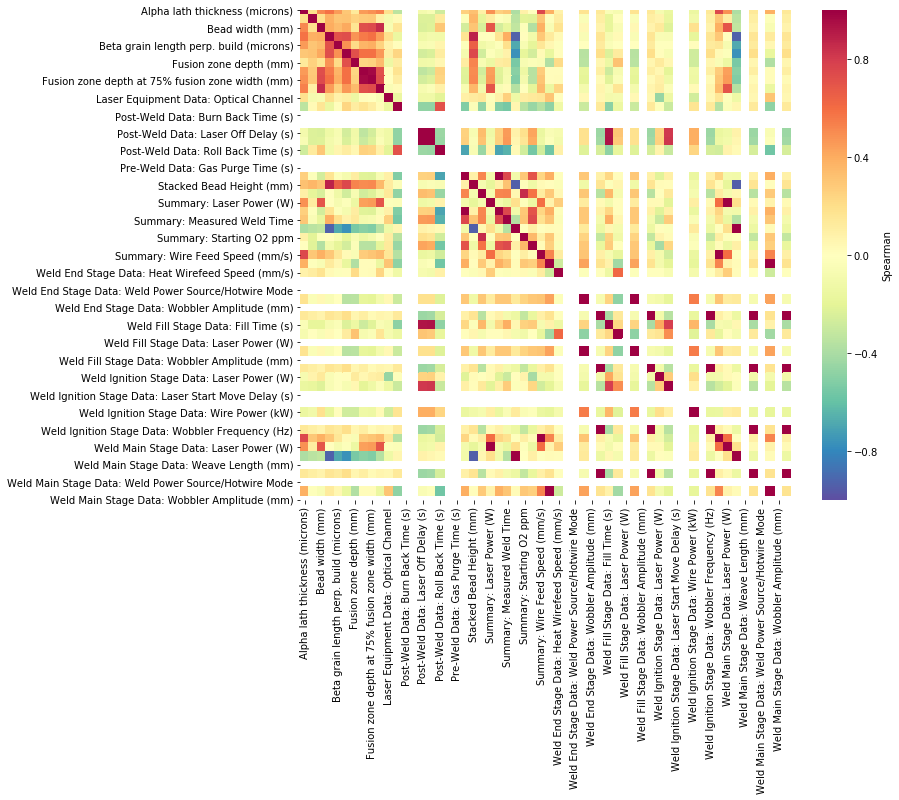

In [4]:
spearman = data.corr("spearman")
plot_correlation(spearman, "Spearman");

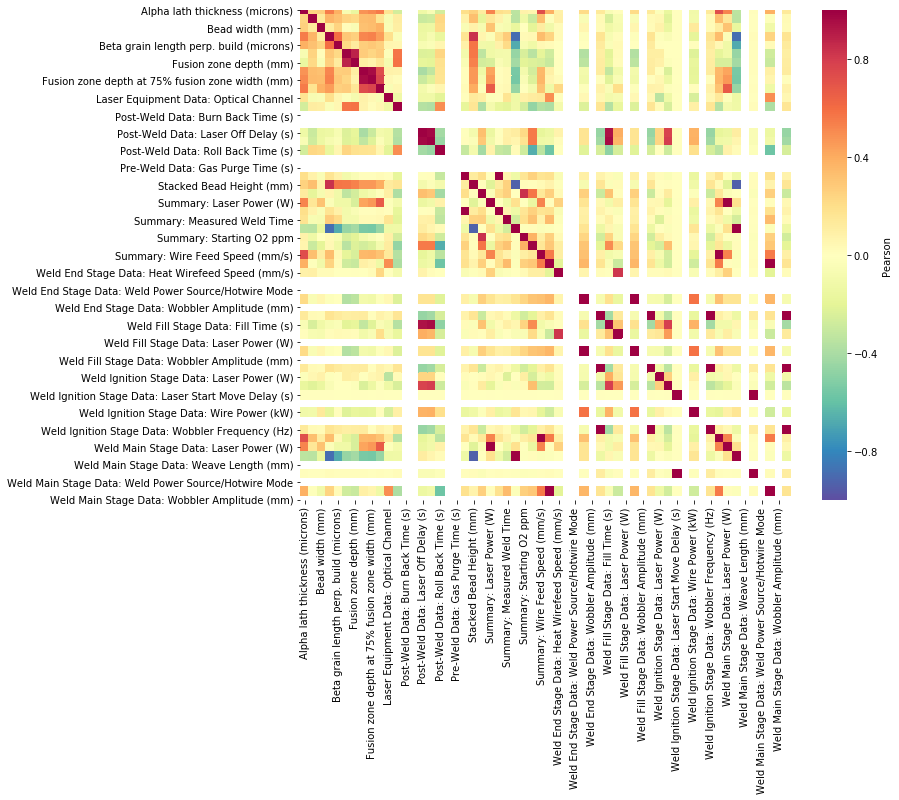

In [5]:
pearson = data.corr("pearson")

plot_correlation(pearson, name="Pearson");

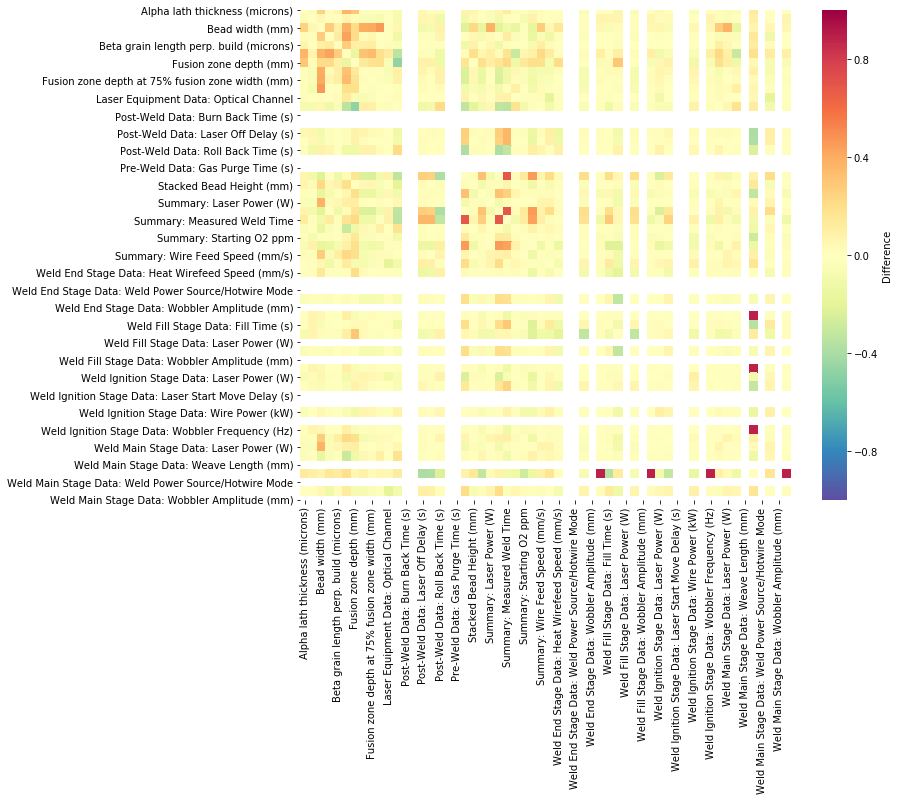

In [6]:
plot_correlation(spearman - pearson, name="Difference");

## Remove columns with non-existent correlation coefficients

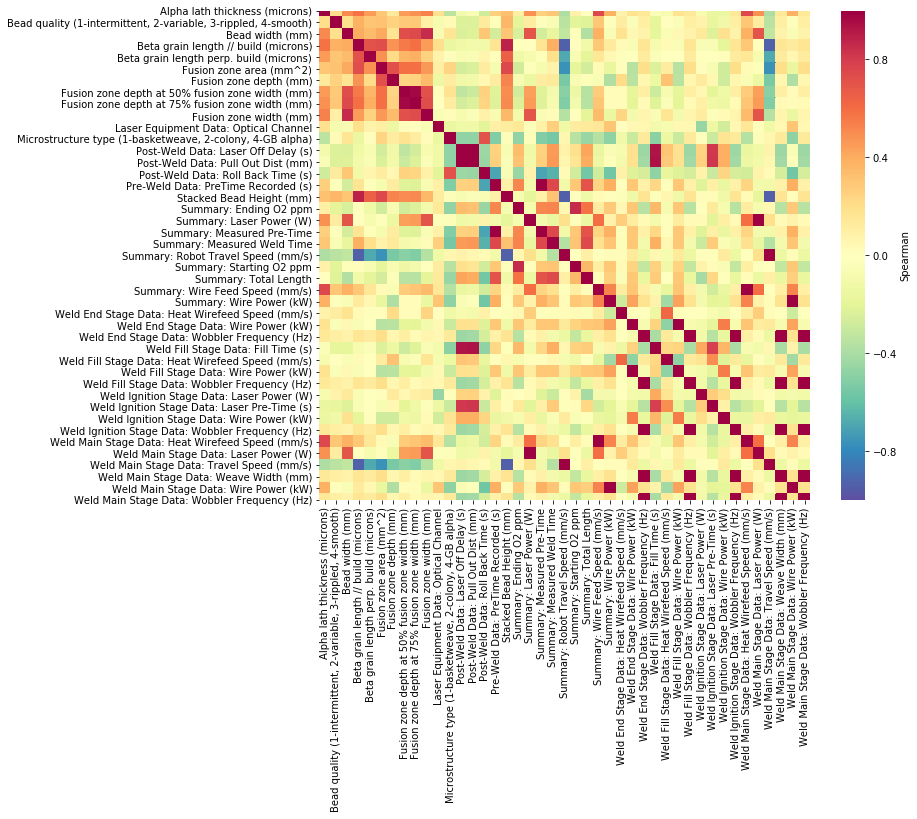

In [7]:
trimmed = data[list(spearman.dropna(how="all").index)]

plot_correlation(trimmed.corr("spearman"), name="Spearman");

## Cluster based on Spearman correlation

In [8]:
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import AgglomerativeClustering

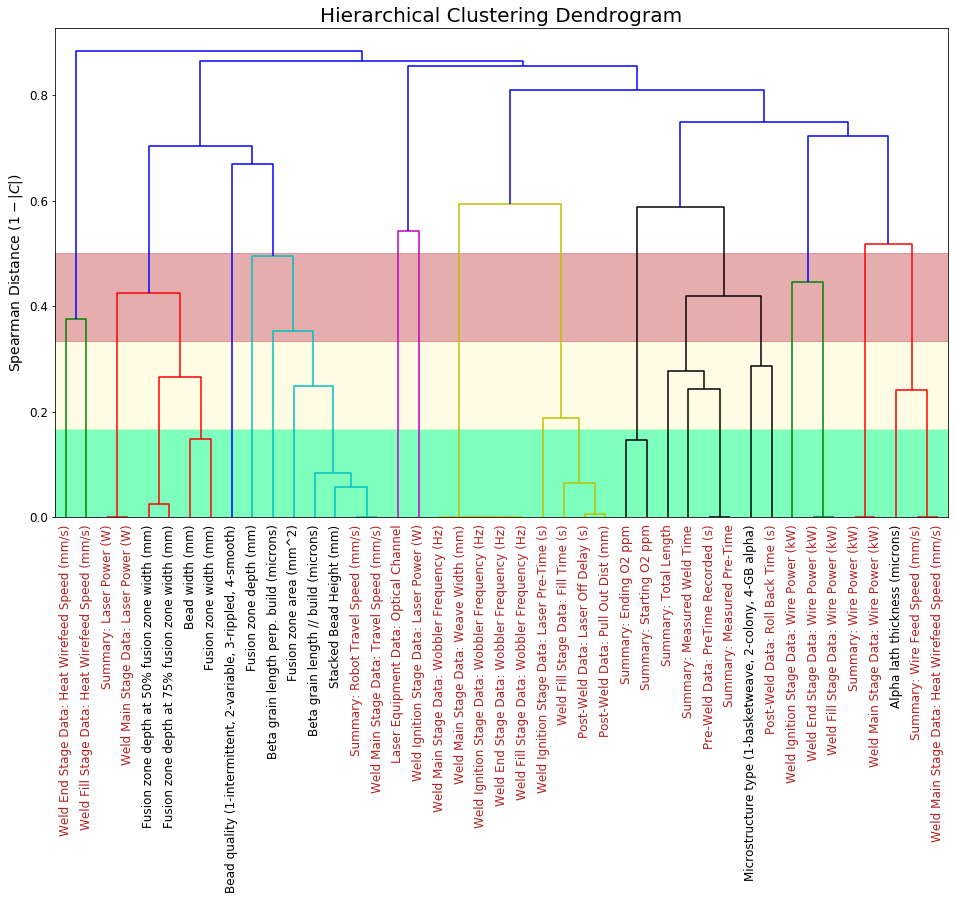

In [9]:
def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    return dendrogram(linkage_matrix, **kwargs);


# map the column names to an index ({#: "name", ...})
labels = {str(i): c for i,c in enumerate(trimmed.columns)}
X = (1 - np.abs(trimmed.corr("spearman"))).values

# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(affinity="precomputed",
                                linkage="average",
                                distance_threshold=0,
                                n_clusters=None)

model = model.fit(X)
# plot the top three levels of the dendrogram
# plot_dendrogram(model, truncate_mode='level', p=3)
fig, ax = plt.subplots(1, 1, figsize=(16, 9));
plot_dendrogram(model, truncate_mode=None, ax=ax)

ax.set_title('Hierarchical Clustering Dendrogram', fontsize=20)
ax.set_xticklabels([labels.get(x.get_text(), "") for x in ax.get_xticklabels()],
                   fontsize=12)#, rotation=45, ha="right")
ax.set_ylabel("Spearman Distance ($1 - |C|$)", fontsize=14)

# draw a horizontal line at a cutoff where merged values have strong, medium, and weakly correlated
ax.axhspan(0, 0.1666, color="springgreen", alpha=0.5)
ax.axhspan(0.1666, 0.3333, color="lemonchiffon", alpha=0.5)
ax.axhspan(0.3333, 0.5, color="indianred", alpha=0.5)

# set color of tick labels to improve grouping/identification
for label in ax.get_xticklabels():
    text = label.get_text()
    if re.match('.*:', text):
        label.set_color("firebrick")
        
for label in ax.get_yticklabels():
    label.set_fontsize(12)

dest = os.path.join(os.path.expanduser("~"),
                    "Desktop",
                    "qm-hierarchical-clustering.png")
plt.savefig(dest, dpi=300, bbox_inches="tight");
plt.show()

# Extract unique features from the hierarchical model

In [231]:
try:
    import networkx as nx
except ImportError:
    import sys
    !{sys.executable} -m pip install networkx
    
try:
    import netgraph
except ImportError:
    import sys
    !{sys.executable} -m pip install netgraph

In [185]:
def get_type(name):
    if re.match('.*:', name):
        return "process"
    else:
        return "response"

g = nx.Graph()
p = nx.Graph()
r = nx.Graph()
# define nodes and labels
g.add_nodes_from([(int(k), {"label": v, "type": get_type(v)}) for k,v in labels.items()])
p.add_nodes_from([(i, {"label": g.nodes[i]["label"], "type": g.nodes[i]["type"]})
                  for i in g.nodes if g.nodes[i]["type"] == "process"])
r.add_nodes_from([(i, {"label": g.nodes[i]["label"], "type": g.nodes[i]["type"]})
                  for i in g.nodes if g.nodes[i]["type"] == "response"])
# add edges
corr = trimmed.corr("spearman").values
for i in range(corr.shape[0]):
    ilabel = g.nodes[i]["label"]
    itype = g.nodes[i]["type"]
    for j in range(i+1, corr.shape[1]):
        jlabel = g.nodes[j]["label"]
        jtype = g.nodes[j]["type"]
        c = corr[i, j]
        w = 1 - np.abs(c)
        if np.abs(c) > 0.5:
            g.add_edge(i, j, corr=c, weight=w, inv_weight=1/(w + 0.05))
            if itype == "process" and jtype == "process":
                p.add_edge(i, j, corr=c, weight=w, inv_weight=1/(w + 0.05))
            if itype == "response" and jtype == "response":
                r.add_edge(i, j, corr=c, weight=w, inv_weight=1/(w + 0.05))

In [156]:
[x for x in nx.__dict__ if re.match('.*layout', x)]

['layout',
 'bipartite_layout',
 'circular_layout',
 'kamada_kawai_layout',
 'random_layout',
 'rescale_layout',
 'shell_layout',
 'spring_layout',
 'spectral_layout',
 'planar_layout',
 'fruchterman_reingold_layout',
 'spiral_layout']

<IPython.core.display.Javascript object>


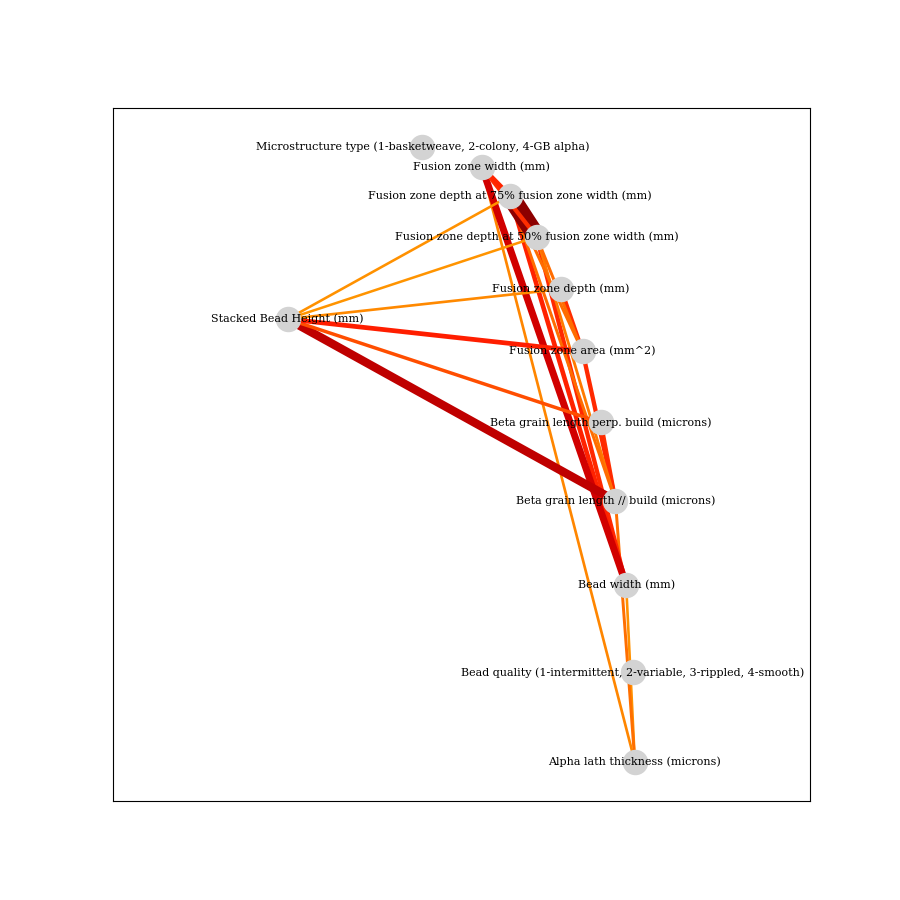

In [230]:
graph = r

pos = nx.kamada_kawai_layout(g, weight='weight');
# pos = nx.bipartite_layout(graph, [i for i in graph.nodes if graph.nodes[i]["type"] == "process"]);

fig, ax = plt.subplots(1, 1, figsize=(9, 9))

nx.draw_networkx_nodes(graph, pos,
                       node_color="lightgray",
                       ax=ax);
nx.draw_networkx_edges(graph, pos,
                       width=[graph.edges[i,j]["inv_weight"] for i,j in graph.edges],
                       edge_color=[graph.edges[i,j]["corr"] for i,j in graph.edges],
                       edge_cmap=plt.cm.jet,
                       edge_vmin=-1,
                       edge_vmax=1,
                       ax=ax);
nx.draw_networkx_labels(graph, pos,
                        labels={i:graph.nodes[i]["label"] for i in graph.nodes},
                        font_size=8,
                        font_family='serif',
                        font_color='k',);

xlo, xhi = ax.get_xlim()
delta = xhi - xlo
ax.set_xlim(xmin=xlo-0.4*delta, xmax=xhi+0.4*delta);

<IPython.core.display.Javascript object>


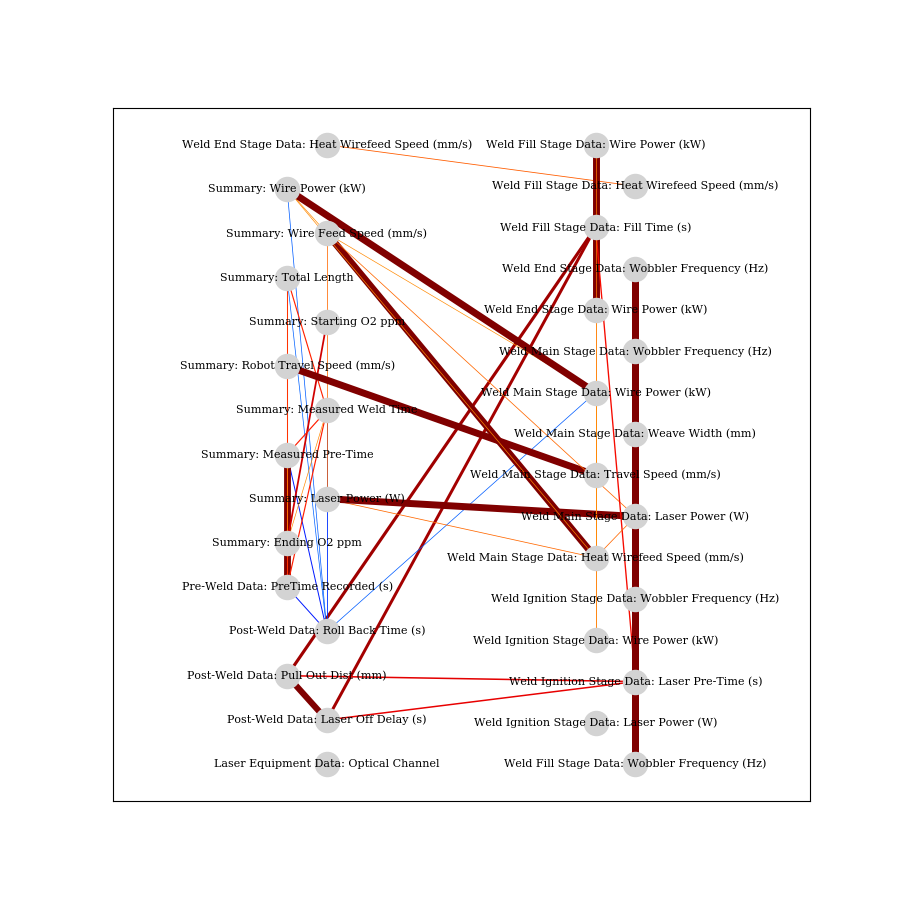

In [228]:
graph = p

nodelist = list(graph.nodes)

# pos = nx.fruchterman_reingold_layout(graph, weight="inv_weight");
pos = nx.bipartite_layout(graph, nodelist[:len(nodelist)//2])
pos = {k:v + (-1)**(k%2)*np.array([0.125, 0]) for k,v in pos.items()}
# pos = nx.circular_layout(graph);
# pos = nx.shell_layout(graph);
# pos = nx.spectral_layout(graph, weight="inv_weight")
# pos = {k:(pos1[k] + pos2[k])/2 for k in pos1}

fig, ax = plt.subplots(1, 1, figsize=(9, 9))

nx.draw_networkx_nodes(graph, pos,
                       node_color="lightgray",
                       ax=ax);
nx.draw_networkx_edges(graph, pos,
                       width=[graph.edges[i,j]["inv_weight"]/4 for i,j in graph.edges],
                       edge_color=[graph.edges[i,j]["corr"] for i,j in graph.edges],
                       edge_cmap=plt.cm.jet,
                       edge_vmin=-1,
                       edge_vmax=1,
                       ax=ax);
nx.draw_networkx_labels(graph, pos,
                        labels={i:graph.nodes[i]["label"] for i in graph.nodes},
                        font_size=8,
                        font_family='serif',
                        font_color='k',);

xlo, xhi = ax.get_xlim()
delta = xhi - xlo
ax.set_xlim(xmin=xlo-0.4*delta, xmax=xhi+0.4*delta);